# 주식 예측 프로젝트

주가 파일 출처: https://finance.yahoo.com/

In [1]:
# 버전 확인
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


총 세 가지: 삼성전자, APPLE, SONY의 주식 예측을 시도해보았다.

## 1. 삼성전자

### STEP 1: 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2: 각종 전처리 수행

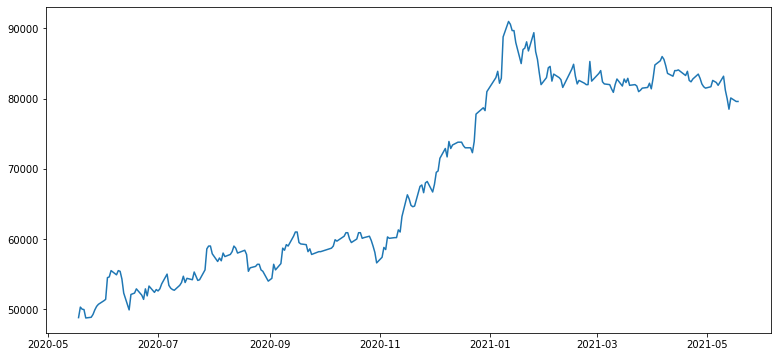

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 결측치 없는 것을 확인

Series([], Name: Close, dtype: float64)

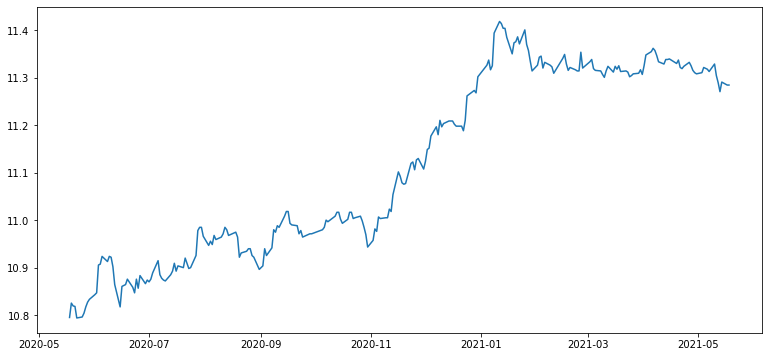

In [5]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [6]:
# 로그변환의 효과 확인: ADF TEST 사용
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

### STEP 3: 시계열 안정성 분석

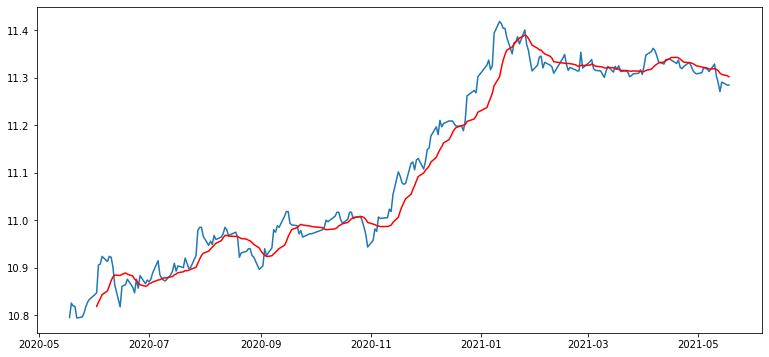

In [8]:
# 정성적 그래프 분석
# trend 상쇄하기
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [9]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

In [10]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

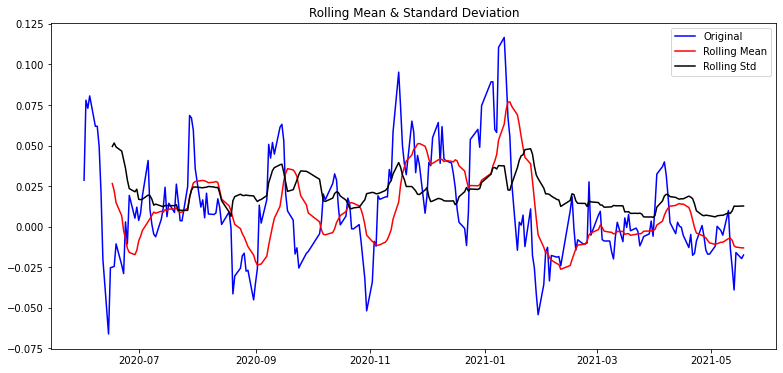

In [11]:
plot_rolling_statistics(ts_log_moving_avg)

In [12]:
# trend 상쇄 효과 확인
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


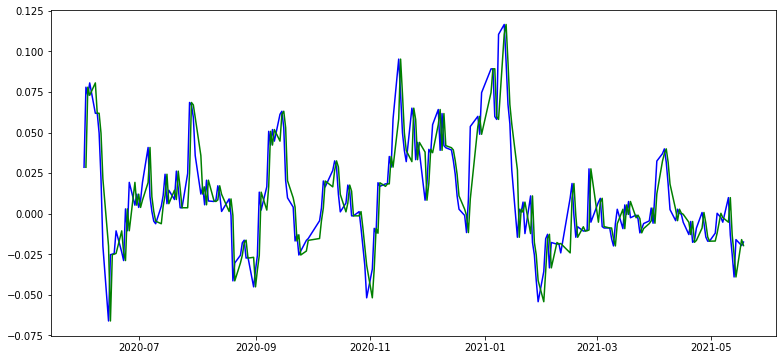

In [13]:
# differencing 상쇄하기
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

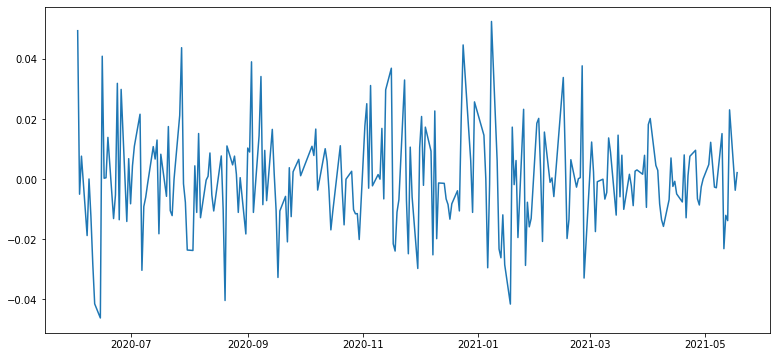

In [14]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

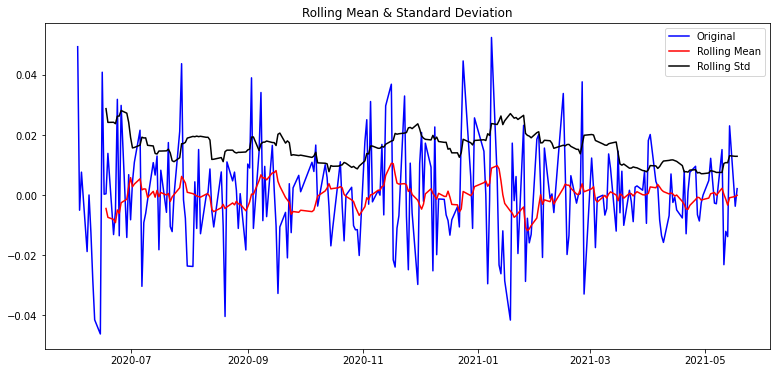

In [15]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

In [16]:
# 차분(differencing) 효과 확인
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


In [17]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


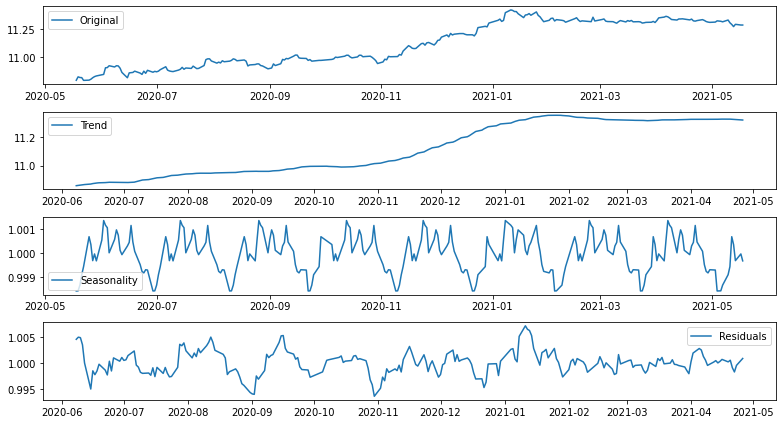

In [18]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

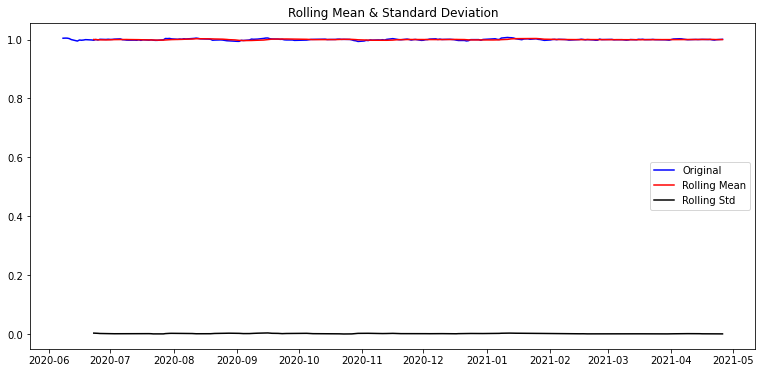

In [19]:
# residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [20]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4: 학습, 테스트 데이터셋 생성

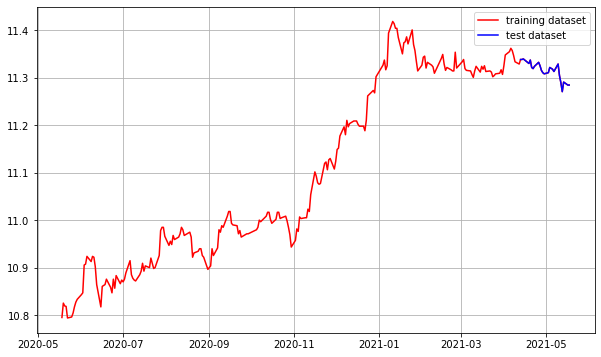

In [21]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5: 적정 ARIMA 모수 찾기

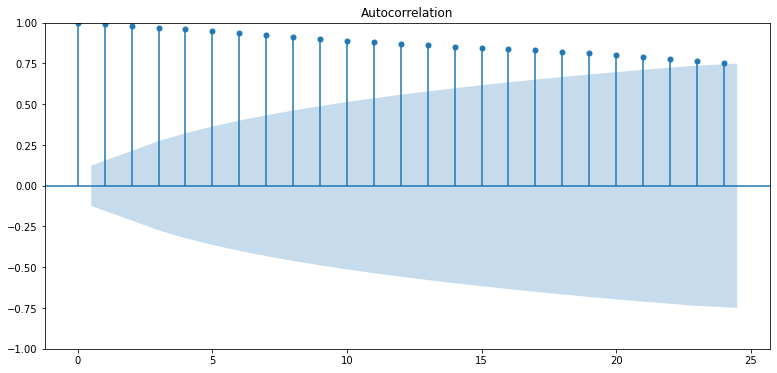

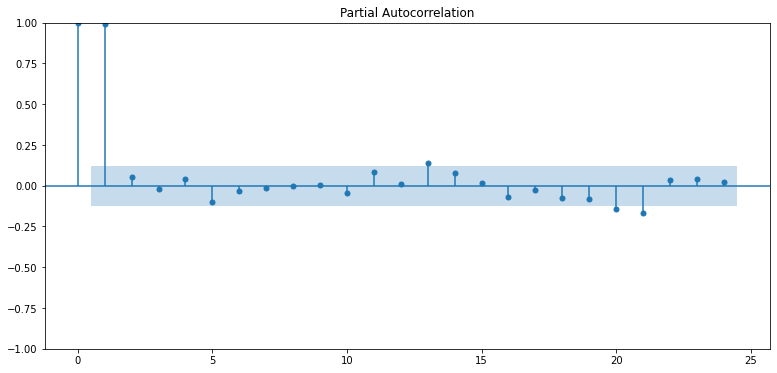

In [22]:
import warnings
warnings.filterwarnings('ignore')

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


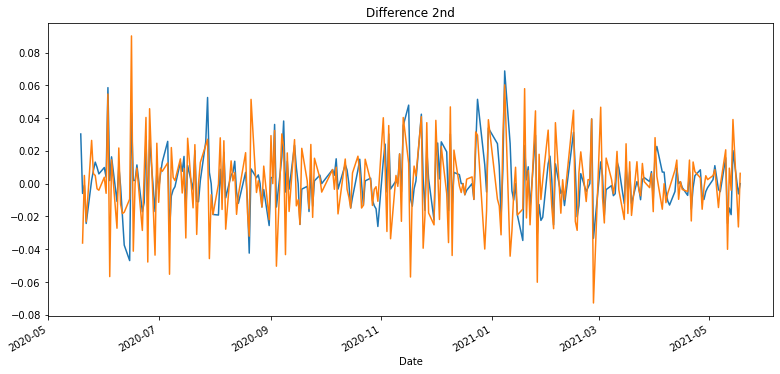

In [23]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6: ARIMA 모델 훈련과 테스트

In [24]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
# PACF가 0이 되기전이 2에 해당되는 것으로 판단
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 30 Sep 2022   AIC                          -1156.722
Time:                        08:17:21   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

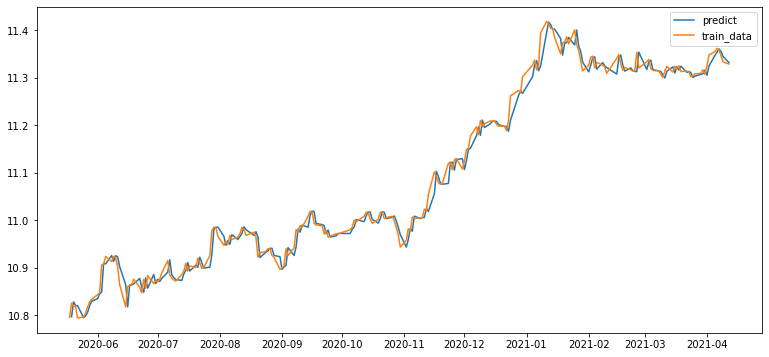

In [25]:
# 훈련 결과 시각적으로 확인
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

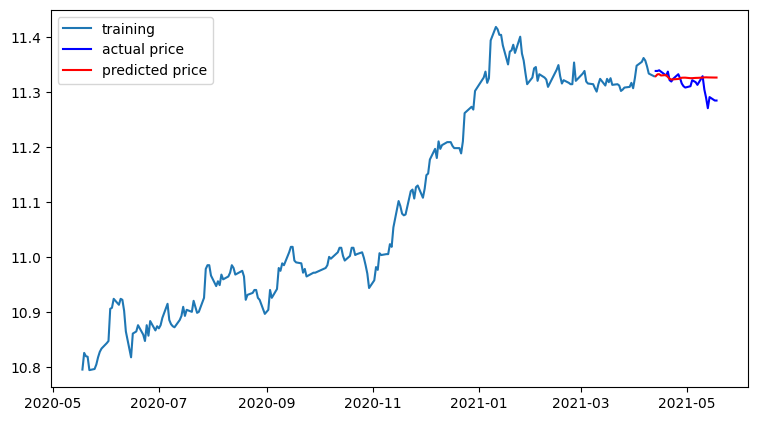

In [26]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [27]:
# 오차 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3005069.905300547
MAE:  1233.7924909538601
RMSE:  1733.5137453451434
MAPE: 1.53%


##  2. APPLE

### STEP 1: 시계열 데이터 준비

In [28]:
# 시계열 데이터 준비
dataset_filepath = os.getenv('HOME')+'/aiffel/project/AAPL.csv'
df1 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts1 = df1['Close']

ts1.head()

Date
2021-09-29    142.830002
2021-09-30    141.500000
2021-10-01    142.649994
2021-10-04    139.139999
2021-10-05    141.110001
Name: Close, dtype: float64

### STEP 2: 각종 전처리 수행

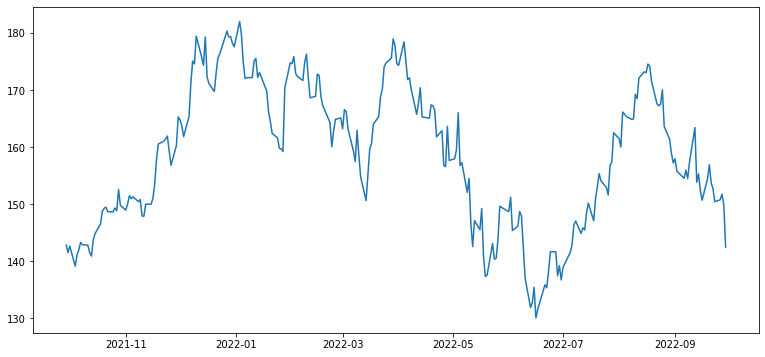

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts1)

In [30]:
# 결측치 처리
ts1 = ts1.interpolate(method='time')
ts1[ts1.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 결측치 없는 것을 확인

Series([], Name: Close, dtype: float64)

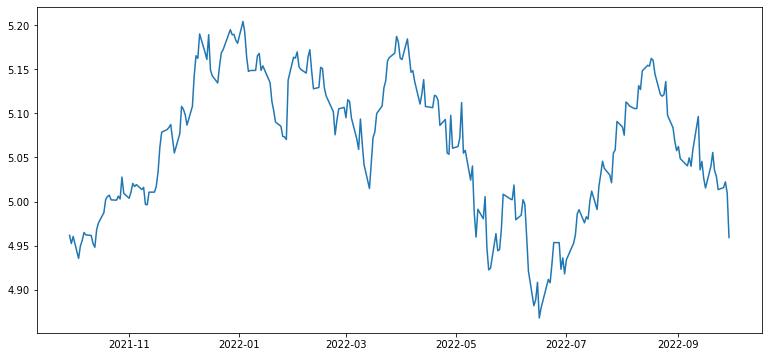

In [31]:
# 로그 변환
ts1_log = np.log(ts1)
plt.plot(ts1_log)

In [32]:
# 로그변환의 효과 확인: ADF TEST 사용
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts1_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.026070
p-value                          0.275260
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [33]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

### STEP 3: 시계열 안정성 분석

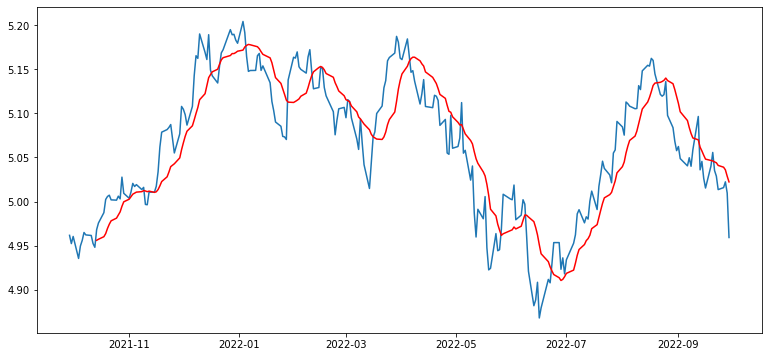

In [34]:
# 정성적 그래프 분석
# trend 상쇄하기
moving_avg = ts1_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts1_log)
plt.plot(moving_avg, color='red')

In [35]:
ts1_log_moving_avg = ts1_log - moving_avg # 변화량 제거
ts1_log_moving_avg.head(15)

Date
2021-09-29         NaN
2021-09-30         NaN
2021-10-01         NaN
2021-10-04         NaN
2021-10-05         NaN
2021-10-06         NaN
2021-10-07         NaN
2021-10-08         NaN
2021-10-11         NaN
2021-10-12         NaN
2021-10-13         NaN
2021-10-14    0.012115
2021-10-15    0.018435
2021-10-18    0.027250
2021-10-19    0.038722
Name: Close, dtype: float64

In [36]:
ts1_log_moving_avg.dropna(inplace=True)
ts1_log_moving_avg.head(15)

Date
2021-10-14    0.012115
2021-10-15    0.018435
2021-10-18    0.027250
2021-10-19    0.038722
2021-10-20    0.036227
2021-10-21    0.032898
2021-10-22    0.023762
2021-10-25    0.020371
2021-10-26    0.021274
2021-10-27    0.014669
2021-10-28    0.033082
2021-10-29    0.009662
2021-11-01    0.001077
2021-11-02    0.005240
2021-11-03    0.012228
Name: Close, dtype: float64

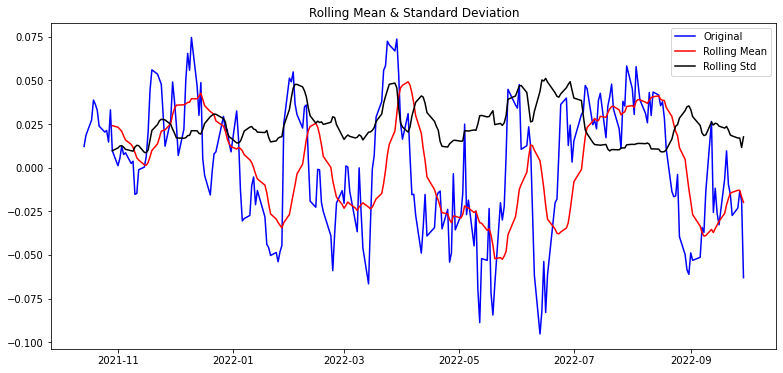

In [37]:
plot_rolling_statistics(ts1_log_moving_avg)

In [38]:
# trend 상쇄 효과 확인
augmented_dickey_fuller_test(ts1_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.039122
p-value                          0.001219
#Lags Used                       0.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


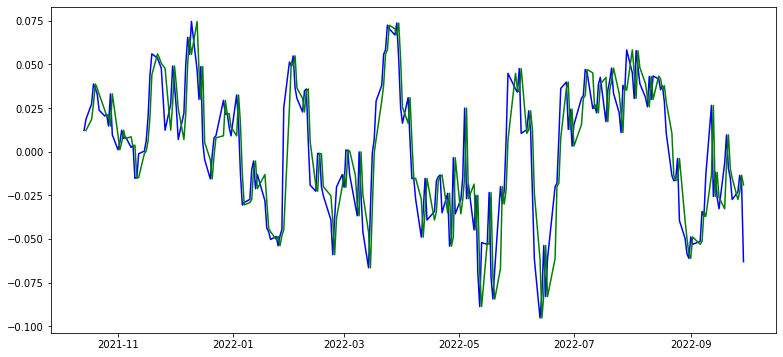

In [39]:
# differencing 상쇄하기
ts1_log_moving_avg_shift = ts1_log_moving_avg.shift()

plt.plot(ts1_log_moving_avg, color='blue')
plt.plot(ts1_log_moving_avg_shift, color='green')

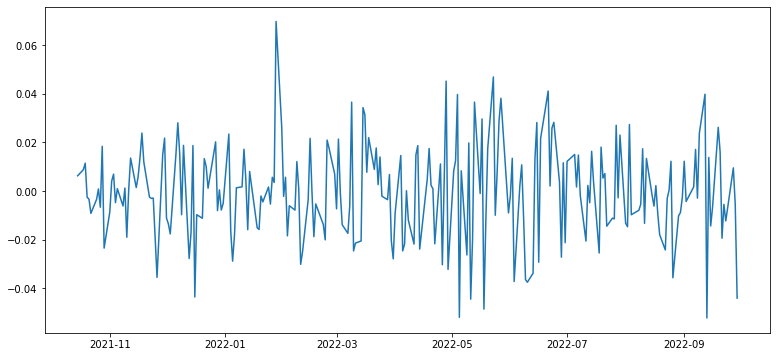

In [40]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현
ts1_log_moving_avg_diff = ts1_log_moving_avg - ts1_log_moving_avg_shift
ts1_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts1_log_moving_avg_diff)

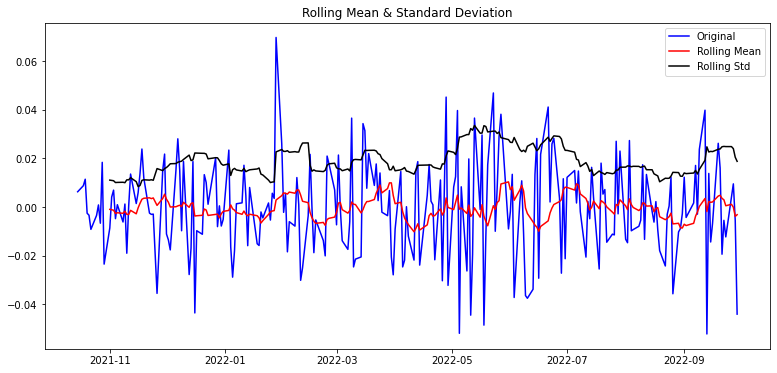

In [41]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts1_log_moving_avg_diff)

In [42]:
# 차분(differencing) 효과 확인
augmented_dickey_fuller_test(ts1_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.328659e+00
p-value                        1.143141e-10
#Lags Used                     9.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


In [43]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.026070
p-value                          0.275260
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


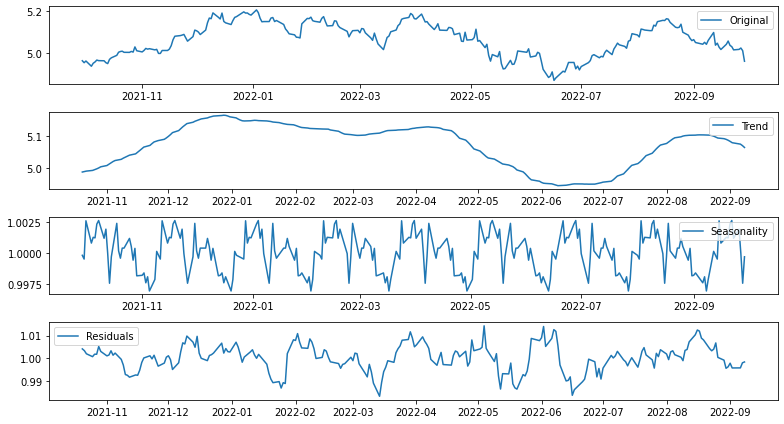

In [44]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

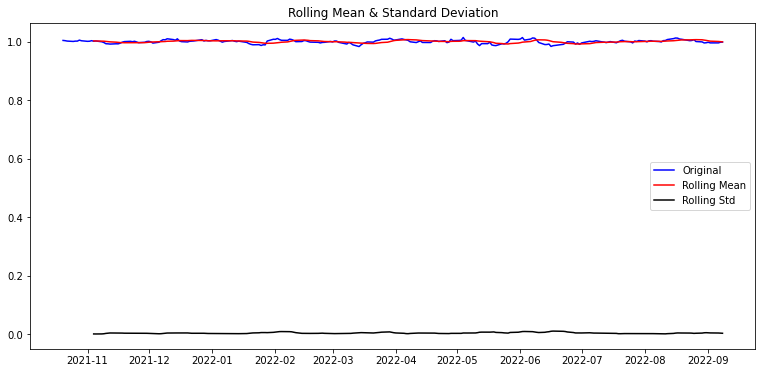

In [45]:
# residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [46]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.017071
p-value                          0.000021
#Lags Used                      11.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


### STEP 4. 학습, 테스트 데이터셋 생성

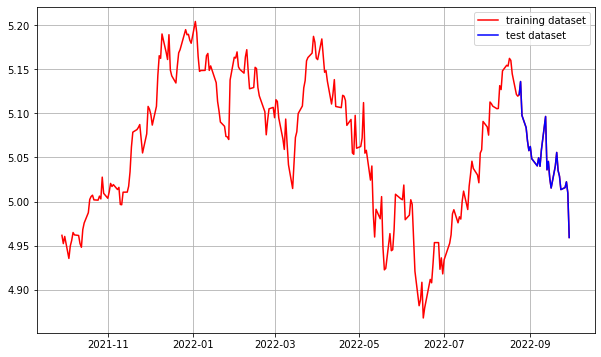

In [47]:
# 학습, 테스트 데이터셋
train_data, test_data = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts1_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5: 적정 ARIMA 모수 찾기

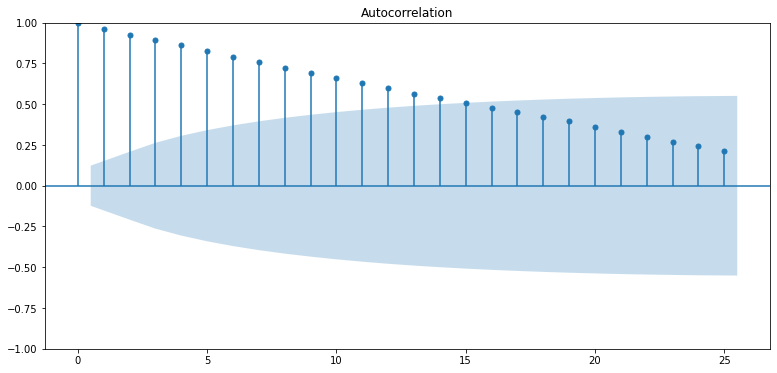

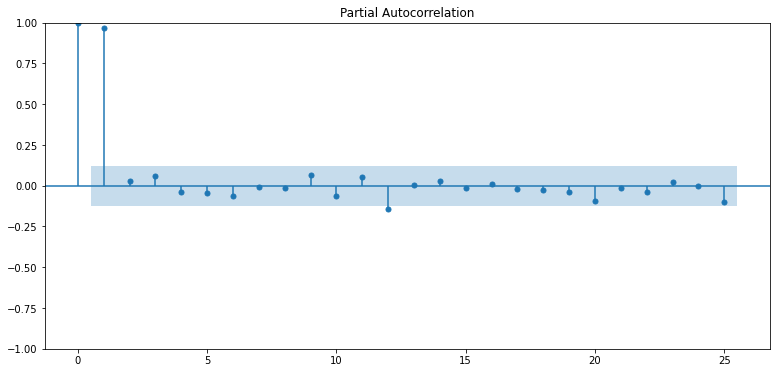

In [48]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.579095e+01
p-value                        1.102389e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.047325e+00
p-value                        4.946247e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


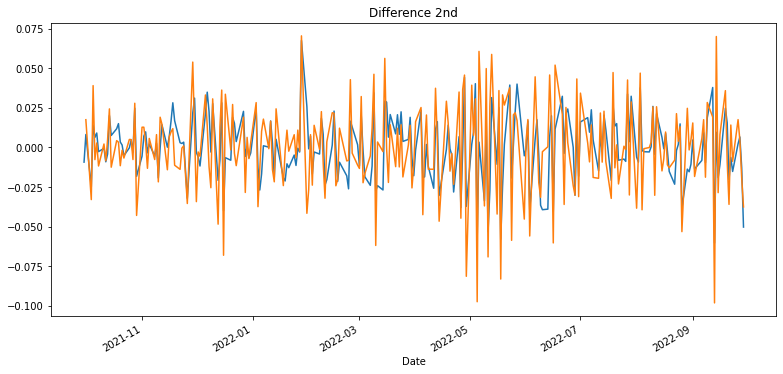

In [49]:
# 1차 차분 구하기
diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6: ARIMA 모델 훈련과 테스트

In [50]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
# PACF가 0이 되기전이 2에 해당되는 것으로 판단
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 570.586
Date:                Fri, 30 Sep 2022   AIC                          -1131.171
Time:                        08:17:29   BIC                          -1114.047
Sample:                             0   HQIC                         -1124.261
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0490      0.321     15.747      0.000       4.421       5.677
ar.L1          0.1284      0.055      2.331      0.020       0.020       0.236
ar.L2          0.8637      0.056     15.406      0.0

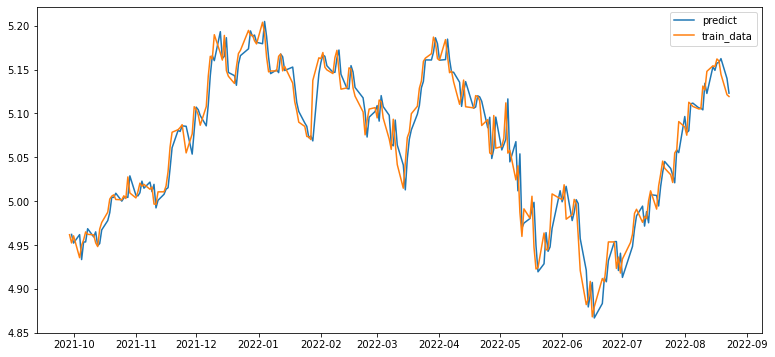

In [51]:
# 훈련 결과 시각적으로 확인
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

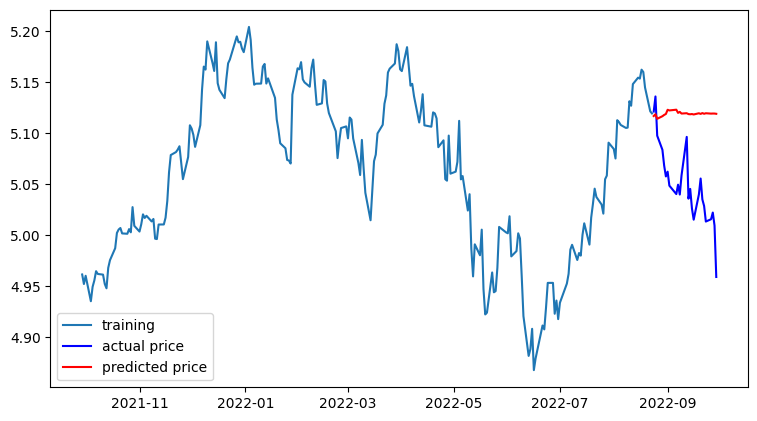

In [52]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [53]:
# 오차 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  161.53560169348737
MAE:  11.572244099352865
RMSE:  12.709665679847262
MAPE: 7.55%


## 3. SONY

### STEP 1. 시계열 데이터 준비

In [54]:
# 시계열 데이터 준비
dataset_filepath = os.getenv('HOME')+'/aiffel/project/SONY.csv'
df2 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts2 = df2['Close']

ts2.head()

Date
2021-09-29    111.480003
2021-09-30    110.580002
2021-10-01    109.510002
2021-10-04    106.970001
2021-10-05    106.709999
Name: Close, dtype: float64

### STEP 2. 각종 전처리 수행

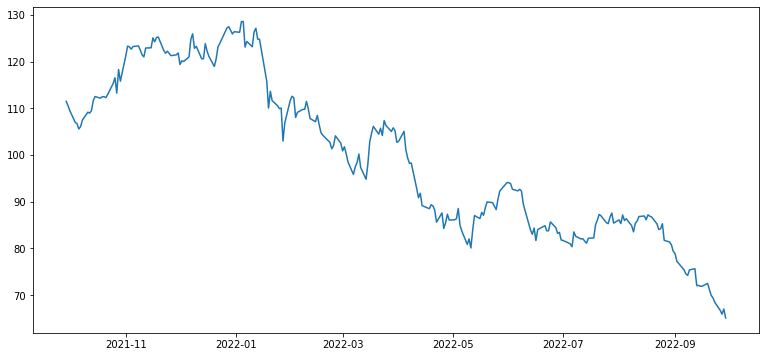

In [55]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts2)

In [56]:
# 결측치 처리
ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 결측치 없는 것을 확인

Series([], Name: Close, dtype: float64)

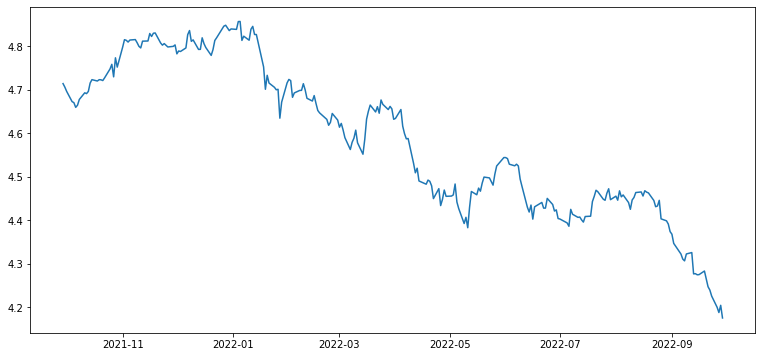

In [57]:
# 로그 변환
ts2_log = np.log(ts2)
plt.plot(ts2_log)

In [58]:
# 로그변환의 효과 확인: ADF TEST 사용
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts1_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.026070
p-value                          0.275260
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [59]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

### STEP 3. 시계열 안정성 분석

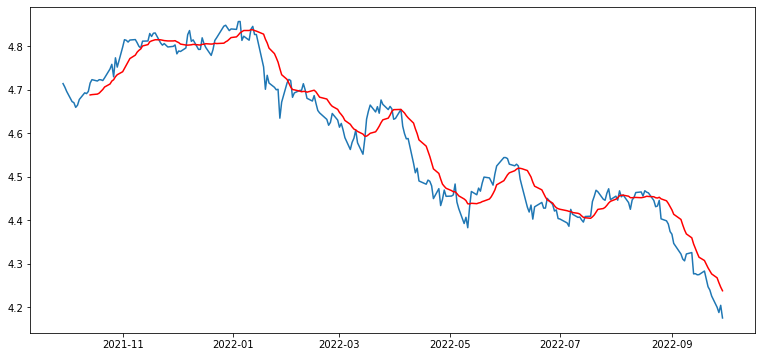

In [60]:
# 정성적 그래프 분석
# trend 상쇄하기
moving_avg = ts2_log.rolling(window=12).mean()  # moving average구하기 
# 연간 데이터이므로 window=12로 둔다
plt.plot(ts2_log)
plt.plot(moving_avg, color='red')

In [61]:
ts2_log_moving_avg = ts2_log - moving_avg # 변화량 제거
ts2_log_moving_avg.head(15)

Date
2021-09-29         NaN
2021-09-30         NaN
2021-10-01         NaN
2021-10-04         NaN
2021-10-05         NaN
2021-10-06         NaN
2021-10-07         NaN
2021-10-08         NaN
2021-10-11         NaN
2021-10-12         NaN
2021-10-13         NaN
2021-10-14    0.027368
2021-10-15    0.034372
2021-10-18    0.030082
2021-10-19    0.030871
Name: Close, dtype: float64

In [62]:
ts2_log_moving_avg.dropna(inplace=True)
ts2_log_moving_avg.head(15)

Date
2021-10-14    0.027368
2021-10-15    0.034372
2021-10-18    0.030082
2021-10-19    0.030871
2021-10-20    0.026434
2021-10-21    0.020510
2021-10-22    0.021072
2021-10-25    0.034542
2021-10-26    0.038424
2021-10-27    0.006638
2021-10-28    0.043502
2021-10-29    0.017487
2021-11-01    0.056599
2021-11-02    0.065957
2021-11-03    0.056706
Name: Close, dtype: float64

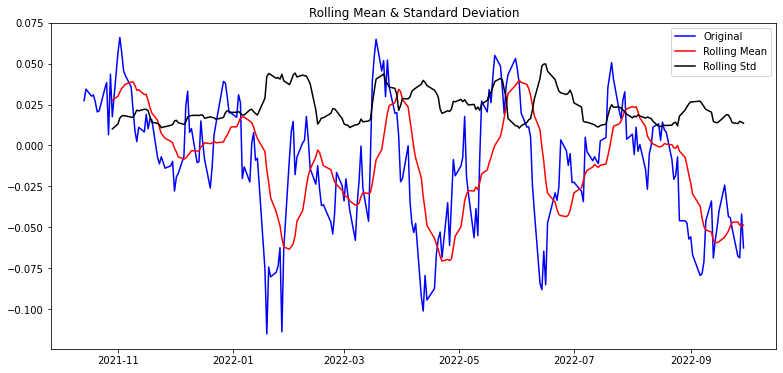

In [63]:
plot_rolling_statistics(ts2_log_moving_avg)

In [64]:
# trend 상쇄 효과 확인
augmented_dickey_fuller_test(ts2_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.664856
p-value                          0.004636
#Lags Used                      15.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64


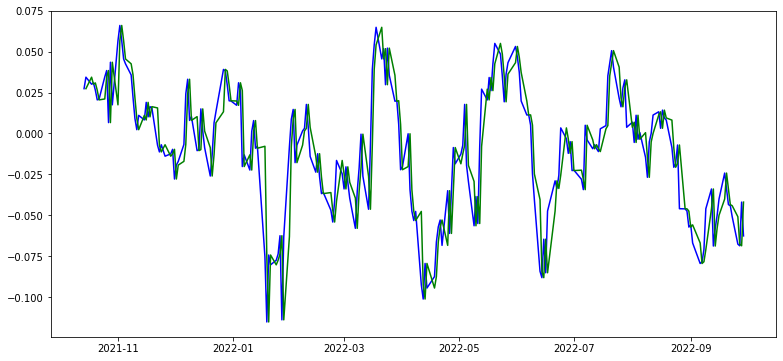

In [65]:
# differencing 상쇄하기
ts2_log_moving_avg_shift = ts2_log_moving_avg.shift()

plt.plot(ts2_log_moving_avg, color='blue')
plt.plot(ts2_log_moving_avg_shift, color='green')

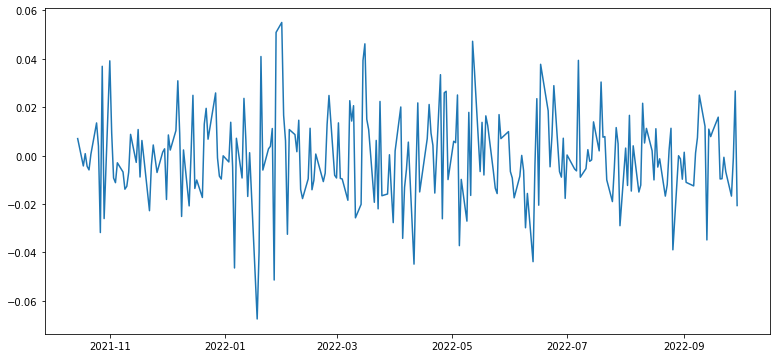

In [66]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현
ts2_log_moving_avg_diff = ts2_log_moving_avg - ts2_log_moving_avg_shift
ts2_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts2_log_moving_avg_diff)

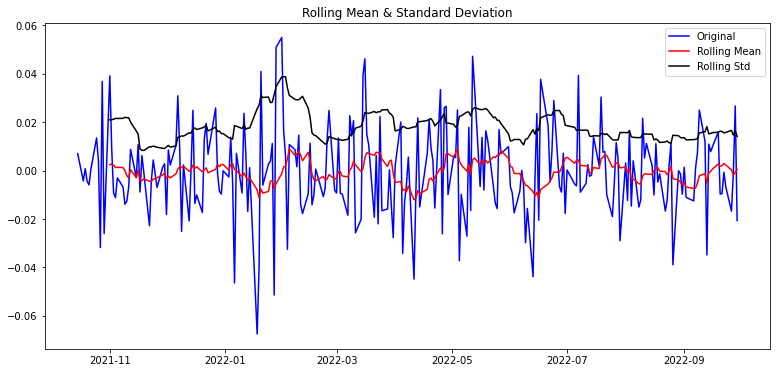

In [67]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts2_log_moving_avg_diff)

In [68]:
# 차분(differencing) 효과 확인
augmented_dickey_fuller_test(ts2_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -5.398424
p-value                          0.000003
#Lags Used                      15.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


In [69]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

Results of Dickey-Fuller Test:
Test Statistic                   0.530980
p-value                          0.985785
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


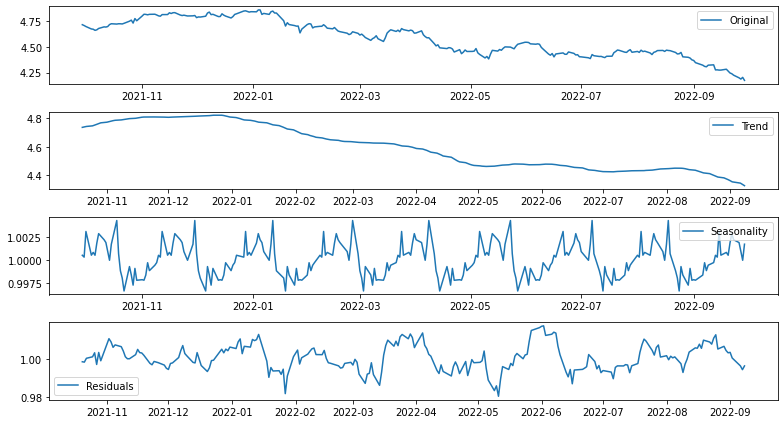

In [70]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

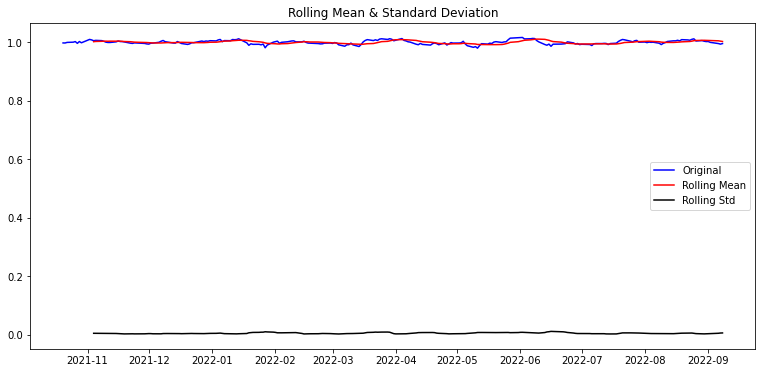

In [71]:
# residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [72]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.778713e+00
p-value                        5.186044e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


### STEP 4. 학습, 테스트 데이터셋 생성

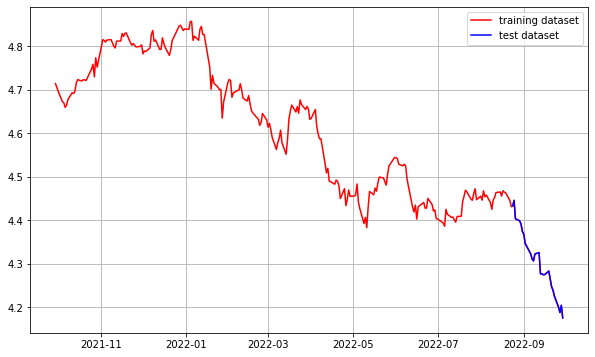

In [73]:
# 학습, 테스트 데이터셋
train_data, test_data = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts1_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5. 적정 ARIMA 모수 찾기

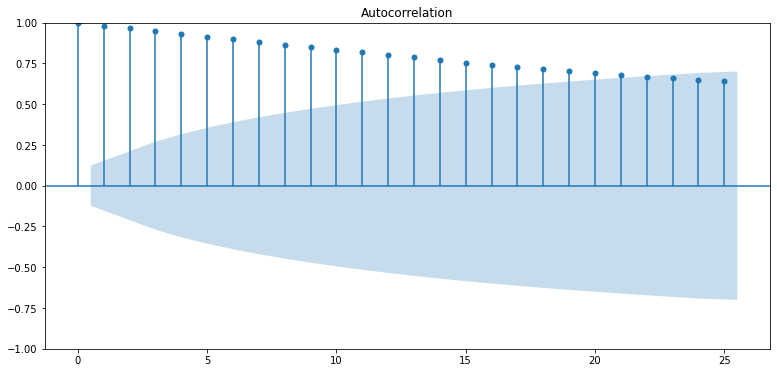

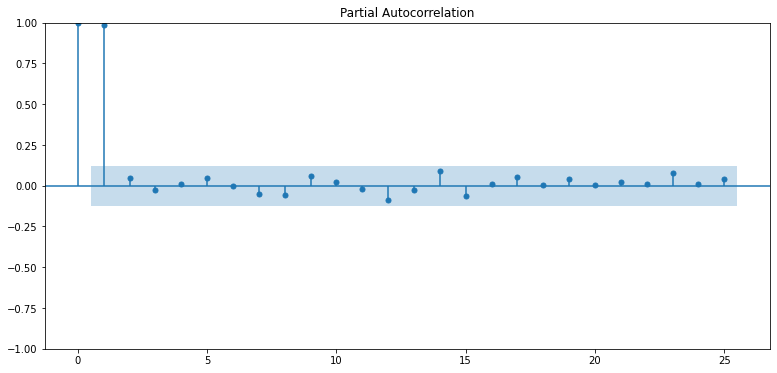

In [74]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.579095e+01
p-value                        1.102389e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.047325e+00
p-value                        4.946247e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


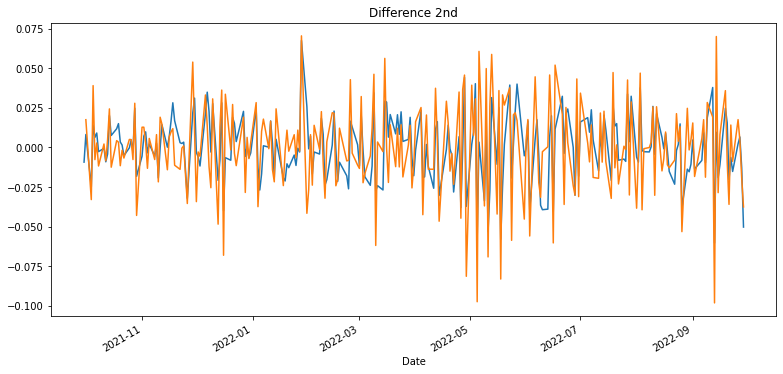

In [75]:
# 1차 차분 구하기
diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 6. ARIMA 모델 훈련과 테스트

In [76]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
# PACF가 0이 되기전이 2에 해당되는 것으로 판단
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 569.908
Date:                Fri, 30 Sep 2022   AIC                          -1129.817
Time:                        08:17:35   BIC                          -1112.692
Sample:                             0   HQIC                         -1122.907
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5931      0.138     33.178      0.000       4.322       4.864
ar.L1          0.1254      0.153      0.820      0.412      -0.174       0.425
ar.L2          0.8602      0.150      5.741      0.0

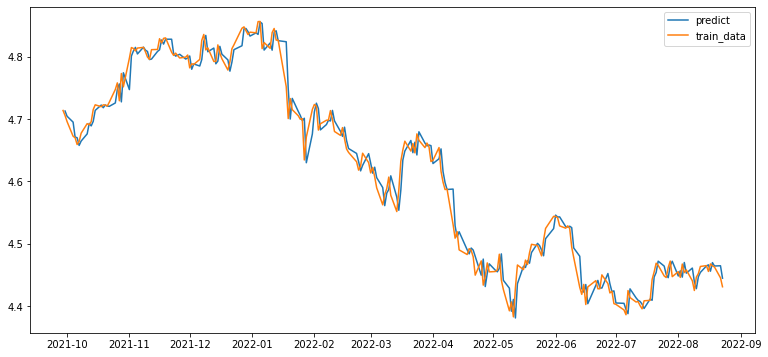

In [77]:
# 훈련 결과 시각적으로 확인
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

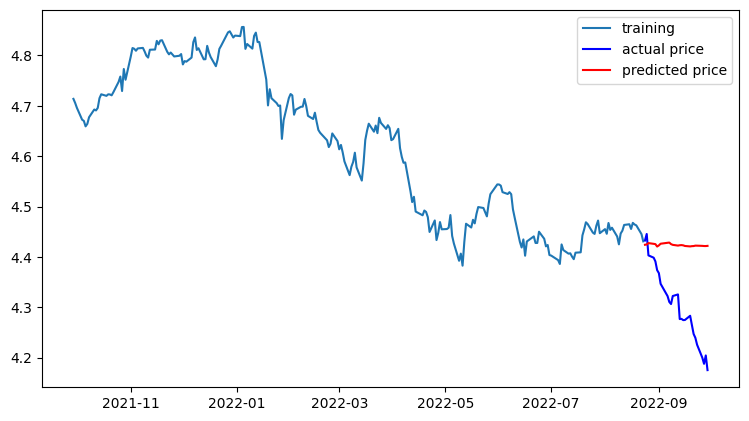

In [78]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [79]:
# 오차 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  115.71420673298408
MAE:  9.458618502508653
RMSE:  10.757053812870144
MAPE: 13.34%


<회고> <br>
주식 예측을 통해 시계열 데이터 분석하는 방법을 대략적으로 배우는 시간이었다. <br>
- 시계열은 time 컬럼을 index로 하는 Time Series 형태의 데이터를 가지고 가공해야 한다.
- 시계열 분석에서는 안정성(정상성, Stationary)이 중요하다: 안정적인 데이터로 만들어서 분석해야 한다.
- 시계열 안정성을 분석하는 방법에는 두 가지가 있다: 정성적 분석, 통계적 분석
- 정성적 분석은 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해서 분석하는 방법이다.
- 통계적 분석은 Augmented Dickey-Fuller Test를 통해 이뤄지는데, 귀무가설/대립가설의 원리를 이용해 p-value 값(작을 수록 좋다)으로 판단한다.
- 두 가지 방법을 통해 데이터가 안정적인지 아닌지 확인할 수 있다.
- 데이터가 Stationary하지 않으면 Stationary 하게 만들어야 한다.
- 기존 시계열을 가공, 변형하거나 / 시계열 분해를 통해 만들 수 있다.
- 최종적으로는 ARIMA라는 시계열 데이터 예측 모델을 통해 모든 과정을 자동으로 만들 수 있다.
- ARIMA에서는 모수를 선택해서 모델 훈련을 시키는데, 모수 선택하는 과정이 중요하다.
- ACF(q 결정), PACF(p 결정)를 통해 각각의 값이 0이 되지 않도록 하는 p, q의 값을 찾는다

<br>
위 방법을 이용하여, MAPE 값을 각각 <br>
삼성전자: 1.53% <br>
APPLE: 7.55% <br>
SONY: 13.34% <br>
으로 구할 수 있었다. <br>
<br>

- 이번에 전체적인 시계열 분석의 흐름에 대해 익힐 수 있었고
- 더 알아보면 좋을 점은: ADF TEST & ARIMA(특히 모수 선택하기)에 대해서.